In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from keras.saving import register_keras_serializable

/Users/leopnt/Data/tracks_match/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocess

In [33]:
def normalize_mel_spectrogram(mel_spectrogram):
    max_val = np.max(mel_spectrogram)
    min_val = np.min(mel_spectrogram)
    normalized_spectrogram = (mel_spectrogram - min_val) / (max_val - min_val)
    return normalized_spectrogram

def make_audio_extracts(audio, sample_duration, sample_rate, num_extracts):
    extract_size = sample_duration * sample_rate

    extracts = []
    for i in range(num_extracts):
        extracts.append(audio[extract_size * (i):extract_size * (i+1)])
    
    return extracts

def preprocess_data(audio_files_folder, csv_file_path, sample_duration=15, sample_rate=44100):
    df = pd.read_csv(csv_file_path)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    spectrograms = []
    labels = []
    for index, row in tqdm(df.head(130).iterrows(), total=len(df.head(130))):
        left_audio, _ = librosa.load(os.path.join(audio_files_folder, row['left']), sr=sample_rate)
        right_audio, _ = librosa.load(os.path.join(audio_files_folder, row['right']), sr=sample_rate)

        #target_sample_size = sample_duration * sample_rate

        #left_audio = left_audio[target_sample_size*4:target_sample_size*5]
        #right_audio = right_audio[target_sample_size*4:target_sample_size*5]

        left_audio_extracts = make_audio_extracts(left_audio, sample_duration, sample_rate, 8)
        sub_left_specs = []
        for extract in left_audio_extracts:
            left_spec = librosa.feature.melspectrogram(y=extract, sr=sample_rate)
            left_spec_db = librosa.power_to_db(S=left_spec, ref=np.max)
            left_spec_db = left_spec_db.T
            left_spec_db = normalize_mel_spectrogram(left_spec_db)

            sub_left_specs.append(left_spec_db)

        right_audio_extracts = make_audio_extracts(right_audio, sample_duration, sample_rate, 8)
        sub_right_specs = []
        for extract in right_audio_extracts:
            right_spec = librosa.feature.melspectrogram(y=extract, sr=sample_rate)
            right_spec_db = librosa.power_to_db(S=right_spec, ref=np.max)
            right_spec_db = right_spec_db.T
            right_spec_db = normalize_mel_spectrogram(right_spec_db)

            sub_right_specs.append(right_spec_db)

        #right_spec = librosa.feature.melspectrogram(y=right_audio, sr=sample_rate)
        #right_spec_db = librosa.power_to_db(S=right_spec, ref=np.max)
        
        # add one channel
        #left_spec_db = left_spec_db.reshape((1, right_spec_db.shape[0], right_spec_db.shape[1]))
        #right_spec_db = right_spec_db.reshape((1, right_spec_db.shape[0], right_spec_db.shape[1]))

        # permute so that it is on the right direction for 1D Convolution layer (slide on the time axis)
        #right_spec_db = right_spec_db.T

        #right_spec_db = normalize_mel_spectrogram(right_spec_db)

        for extract_left_spec, extract_right_spec in zip(sub_left_specs, sub_right_specs):
            spectrograms.append([extract_left_spec, extract_right_spec])
            labels.append(row['match'])
    
    return np.array(spectrograms), np.array(labels).astype(int)

In [34]:
audio_files_folder = 'tracks/'
csv_file_path = 'audio_matrix.csv'
sample_rate = 22050

# Preprocess data
X, y = preprocess_data(audio_files_folder, csv_file_path, sample_duration=15, sample_rate=sample_rate)

 17%|█▋        | 22/130 [00:28<02:19,  1.29s/it]Note: Illegal Audio-MPEG-Header 0xdcbda5a7 at offset 281765.
Note: Trying to resync...
/var/folders/tl/147snmln0854h11g0dg5_hb00000gn/T/ipykernel_62457/345508286.py:24: UserWarning: PySoundFile failed. Trying audioread instead.
  right_audio, _ = librosa.load(os.path.join(audio_files_folder, row['right']), sr=sample_rate)
/Users/leopnt/Data/tracks_match/env/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1365] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
 49%|████▉     | 64/130 [01:24<01:25,  1.30s/it]Note: Illegal Audio-MPEG-Header 0xff6c11bc at offset 8108027.
Note: Trying to resync...
Note: Skip

In [35]:
left, right = X[0]
print(left.shape)

(646, 128)


In [36]:
# to get the mel-spectrogram back in the original shape
left.T.shape

(128, 646)

In [37]:
def plot_spec_pair(left, right):
    fig, (ax1, ax2) = plt.subplots(2)
    img = librosa.display.specshow(left.T, x_axis='time',
                            y_axis='mel', sr=sample_rate,ax=ax1)

    ax1.set(title='Mel-frequency spectrogram, left track')

    img = librosa.display.specshow(right.T, x_axis='time',
                            y_axis='mel', sr=sample_rate,ax=ax2)

    ax2.set(title='Mel-frequency spectrogram right track')
    plt.tight_layout()
    plt.show()

Is Match: 1


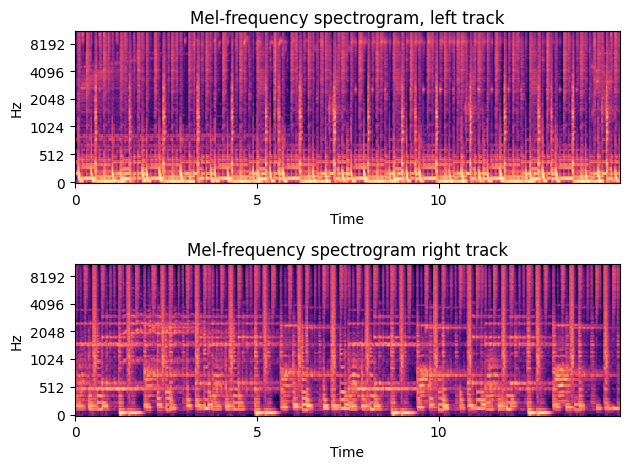

In [38]:
print(f"Is Match: {y[0*8+4]}")
left, right = X[0*8+4]
plot_spec_pair(left, right)

Is Match: 0


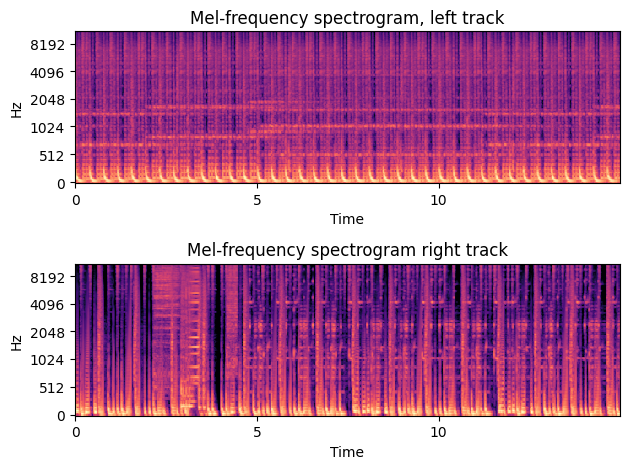

In [18]:
print(f"Is Match: {y[9*8+4]}")
left, right = X[9*8+4]
plot_spec_pair(left, right)

## Define model

In [19]:
def euclidean_distance(vecs):
    (left, right) = vecs
    ss = K.sum(K.square(left - right), axis = 1, keepdims=True)
    return K.sqrt(K.maximum(ss, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, _ = shapes
    return (shape1[0], 1)

def l2_pool_function(x):
    return tf.norm(x, axis=1)

#def custom_sigmoid(x):
#    return 1 / (1 + K.exp(10 * x - 0.5 * 10))

In [20]:
def siamese_submodel(input_shape):
    input_layer = layers.Input(input_shape)
    
    conv1 = layers.Conv1D(256, kernel_size=4, activation='selu')(input_layer)
    maxpool1 = layers.MaxPooling1D(pool_size=4)(conv1)
    
    conv2 = layers.Conv1D(256, kernel_size=4, activation='selu')(maxpool1)
    maxpool2 = layers.MaxPooling1D(pool_size=2)(conv2)
    
    conv3 = layers.Conv1D(512, kernel_size=4, activation='selu')(maxpool2)
    maxpool3 = layers.MaxPooling1D(pool_size=2)(conv3)
    
    # Global temporal pooling
    avg_pool = layers.GlobalAveragePooling1D()(maxpool3)
    max_pool = layers.GlobalMaxPooling1D()(maxpool3)
    l2_pool = layers.Lambda(l2_pool_function, output_shape=(512,))(maxpool3)

    global_pool = layers.Concatenate()([avg_pool, max_pool, l2_pool])

    fc1 = layers.Dense(2048, activation='selu')(global_pool)
    fc2 = layers.Dense(2048, activation='selu')(fc1)
    fc3 = layers.Dense(256, activation='selu')(fc2)
    
    model = Model(inputs=input_layer, outputs=fc3)
    return model

def siamese_model(input_shape):
    input_left = layers.Input(shape=input_shape)
    input_right = layers.Input(shape=input_shape)
    
    submodel = siamese_submodel(input_shape)
    
    encoded_left = submodel(input_left)
    encoded_right = submodel(input_right)
    
    distance = layers.Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([encoded_left, encoded_right])

    #prediction = layers.Lambda(custom_sigmoid)(distance)
    
    #prediction = layers.Dense(1, activation=tf.keras.layers.LeakyReLU(negative_slope=0.01))(distance)
    
    # Create model
    model = Model(inputs=[input_left, input_right], outputs=distance)
    return model

In [124]:
submodel = siamese_submodel(input_shape=(646, 128))
submodel.summary()

Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_43      │ (None, 646, 128)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_51 (Conv1D)  │ (None, 643, 256)  │    131,328 │ input_layer_43[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_51    │ (None, 160, 256)  │          0 │ conv1d_51[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_52 (Conv1D)  │ (None, 157, 256)  │    262,400 │ max_pooling1d_51… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_52    │ (None, 78, 256)   │          0 │ conv1d_52[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_53 (Conv1D)  │ (None, 75, 512)   │    524,800 │ max_pooling1d_52… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_53    │ (None, 37, 512)   │          0 │ conv1d_53[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ max_pooling1d_53… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ max_pooling1d_53… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_32 (Lambda)  │ (None, 512)       │          0 │ max_pooling1d_53… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_17      │ (None, 1536)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ lambda_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, 2048)      │  3,147,776 │ concatenate_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_54 (Dense)    │ (None, 2048)      │  4,196,352 │ dense_53[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_55 (Dense)    │ (None, 256)       │    524,544 │ dense_54[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,787,200 (33.52 MB)

 Trainable params: 8,787,200 (33.52 MB)

 Non-trainable params: 0 (0.00 B)

In [125]:
X[0][0].shape

(646, 128)

In [126]:
submodel(X[0][0].reshape(1, 646, 128)).shape

TensorShape([1, 256])

In [127]:
model = siamese_model(input_shape=(646, 128))
model.summary()

Model: "functional_59"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_44      │ (None, 646, 128)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_45      │ (None, 646, 128)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_57       │ (None, 256)       │  8,787,200 │ input_layer_44[0… │
│ (Functional)        │                   │            │ input_layer_45[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_34 (Lambda)  │ (None, 1)         │          0 │ functional_57[0]… │
│                     │                   │            │ functional_57[1]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,787,200 (33.52 MB)

 Trainable params: 8,787,200 (33.52 MB)

 Non-trainable params: 0 (0.00 B)

In [128]:
left = X[0][0].reshape(1, 646, 128)
right = X[0][1].reshape(1, 646, 128)
model((left, right))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.59417754]], dtype=float32)>

## Train

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
def contrastive_loss(y_true, y_pred, margin=1):
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [39]:
model = siamese_model(input_shape=(646, 128))
rms = Adam(learning_rate=0.0005)

model.compile(loss=contrastive_loss, optimizer=rms)

history = model.fit(
    [X_train[:, 0], X_train[:, 1]], y_train[:],
    validation_data=([X_test[:, 0], X_test[:, 1]], y_test[:]),
    batch_size = 32,
    epochs = 20)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - loss: 6.1100 - val_loss: 0.3821
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.2689 - val_loss: 0.5967
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.2480 - val_loss: 0.2126
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.2083 - val_loss: 0.2794
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.2034 - val_loss: 0.2042
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.1681 - val_loss: 0.2430
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.1350 - val_loss: 0.1411
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.1162 - val_loss: 0.1936
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.1452 - val_loss: 0.1485
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0978 - val_loss: 0.1369
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0991 - val_loss: 0.1283
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step

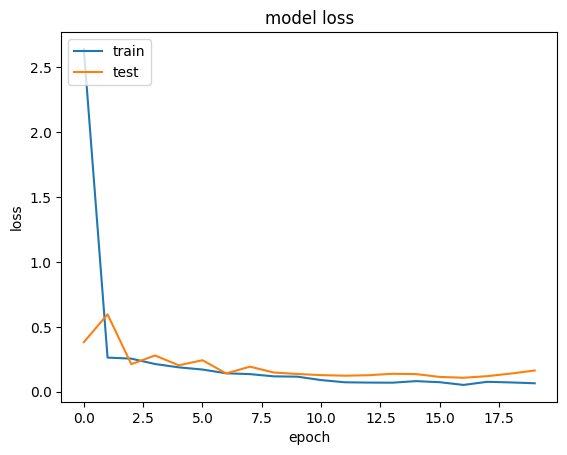

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predict

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted: 1, true: 1


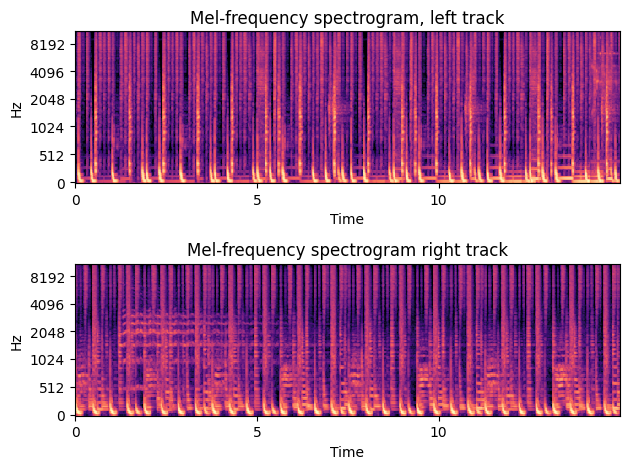

In [44]:
img_id = 2
left = X[img_id][0].reshape(1, 646, 128)
right = X[img_id][1].reshape(1, 646, 128)

predicts = model.predict([left, right])
proba = predicts[0][0]
print(f"Predicted: {int(proba < 0.5)}, true: {y[img_id]}")
plot_spec_pair(left.squeeze(), right.squeeze())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted: 0, true: 0


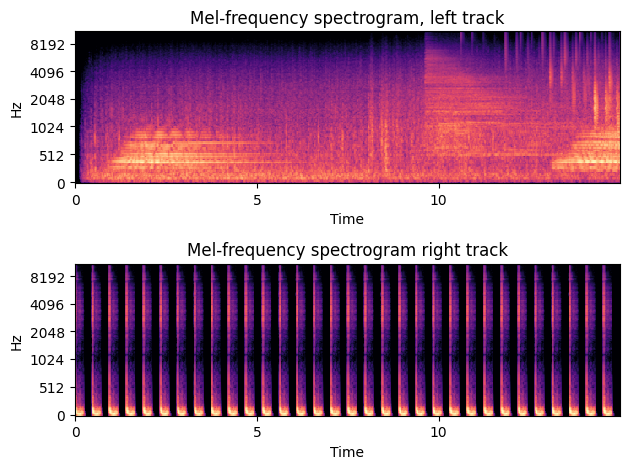

In [42]:
img_id = 200
left = X[img_id][0].reshape(1, 646, 128)
right = X[img_id][1].reshape(1, 646, 128)

predicts = model.predict([left, right])
proba = predicts[0][0]
print(f"Predicted: {int(proba < 0.5)}, true: {y[img_id]}")
plot_spec_pair(left.squeeze(), right.squeeze())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted: 1, true: 1


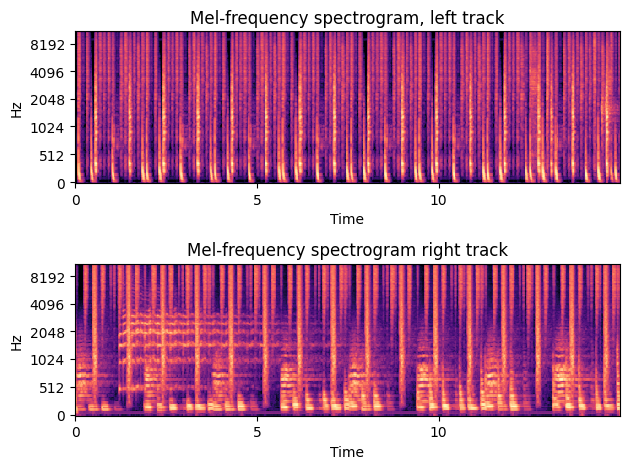

In [28]:
img_id = 0
left = X[img_id][0].reshape(1, 646, 128)
right = X[img_id][1].reshape(1, 646, 128)

predicts = model.predict([left, right])
proba = predicts[0][0]
print(f"Predicted: {int(proba < 0.5)}, true: {y[img_id]}")
plot_spec_pair(left.squeeze(), right.squeeze())

In [45]:
predictions_proba = model.predict([X_train[:,0], X_train[:,1]]).ravel()
predictions = (predictions_proba < 0.5).astype(int)
print(f"train accuracy: {np.mean(predictions == y_train)}")

predictions_proba = model.predict([X_test[:,0], X_test[:,1]]).ravel()
predictions = (predictions_proba < 0.5).astype(int)
print(f"test accuracy: {np.mean(predictions == y_test)}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
train accuracy: 0.88125
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
test accuracy: 0.8375


## Export model

In [30]:
# Save the model
tf.keras.models.save_model(model, './melspec_similarity_estimator.keras')